In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.model_h import GQEstimatorH
from src.model import GQEstimator
from src.dataset import GraspDataset

dataset = GraspDataset(Path("data/processed"), preload=False)

Found 15547 scenes


# GQ Ordering Evaluation

Initializing GQEstimator
Input size: 48
Flattened size: 1728
Number of parameters: 1041873


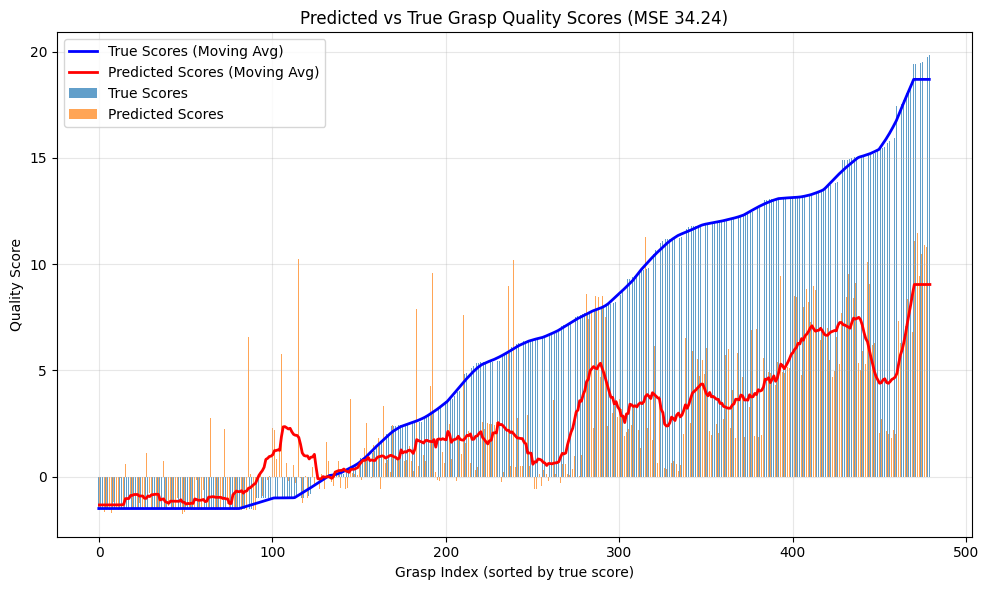

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "checkpoints/gq/hi0718-5M-b128-llr1e-3-m_l_base_8_cont.pth"
# model_path = "checkpoints/gq/lu1-100k-b128-lr3.pth"
model = GQEstimatorH(input_size=48, base_channels=8, fc_dims=[512, 128, 64])
# model = GQEstimator(input_size=48, base_channels=16, fc_dims=[32, 16])
weights = torch.load(model_path, map_location=device)
# weights = { k.replace("_orig_mod.", ""): v for (k, v) in weights.items() }
# torch.save(weights, model_path)
model.load_state_dict(weights)
model.to(device)
model.eval()

with np.load(dataset.data_files[0]) as scene_data:
    sdf = scene_data["sdf"]
    translation = scene_data["translation"]
    scale = scene_data["global_scale"]
    grasps = scene_data["grasps"]
    scores = scene_data["scores"]

# Encode sdf
sdf = torch.from_numpy(sdf).float()
sdf = sdf.to(device)
sdf_features = model.encode_sdf(sdf.unsqueeze(0))

# Evaluate grasps
grasps = torch.from_numpy(grasps).float()
grasps = grasps.to(device)

scores_pred = []

for grasp in grasps:
    features = torch.cat([sdf_features, grasp.unsqueeze(0)], dim=1)
    score_pred = model(features)
    scores_pred.append(score_pred)

scores_pred = torch.tensor(scores_pred).cpu().numpy()

# Compute MSE between predicted and true scores
mse = np.mean((scores_pred - scores) ** 2)

# Plot predicted vs true qualities
plt.figure(figsize=(10, 6))

# Sort both arrays by true scores for better visualization
sort_idx = np.argsort(scores)
scores_sorted = scores[sort_idx]
scores_pred_sorted = scores_pred[sort_idx]

x = np.arange(len(scores))
width = 0.35  # Width of bars

# Plot bars
plt.bar(x - width/2, scores_sorted, width, label='True Scores', alpha=0.7)
plt.bar(x + width/2, scores_pred_sorted, width, label='Predicted Scores', alpha=0.7)

# Calculate and plot moving averages
window = 20  # Window size for moving average
true_ma = np.pad(np.convolve(scores_sorted, np.ones(window)/window, mode='valid'),
                 (window//2, (window-1)//2), mode='edge')
pred_ma = np.pad(np.convolve(scores_pred_sorted, np.ones(window)/window, mode='valid'),
                 (window//2, (window-1)//2), mode='edge')
ma_x = x

plt.plot(ma_x - width/2, true_ma, 'blue', label='True Scores (Moving Avg)', linewidth=2)
plt.plot(ma_x + width/2, pred_ma, 'red', label='Predicted Scores (Moving Avg)', linewidth=2)

plt.xlabel('Grasp Index (sorted by true score)')
plt.ylabel('Quality Score')
plt.title(f'Predicted vs True Grasp Quality Scores (MSE {mse:.2f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()


# Grasp Configuration Distribution

In [ ]:
from tqdm import tqdm

# Collect all grasp configurations
grasps = np.array([])
for path in tqdm(dataset.data_files[:3000], desc="Loading grasps"):
    data = np.load(path)
    if len(grasps) == 0:
        grasps = data["grasps"]
    else:
        grasps = np.vstack((grasps, data["grasps"]))

Loading grasps: 100%|██████████| 3000/3000 [00:45<00:00, 66.26it/s]


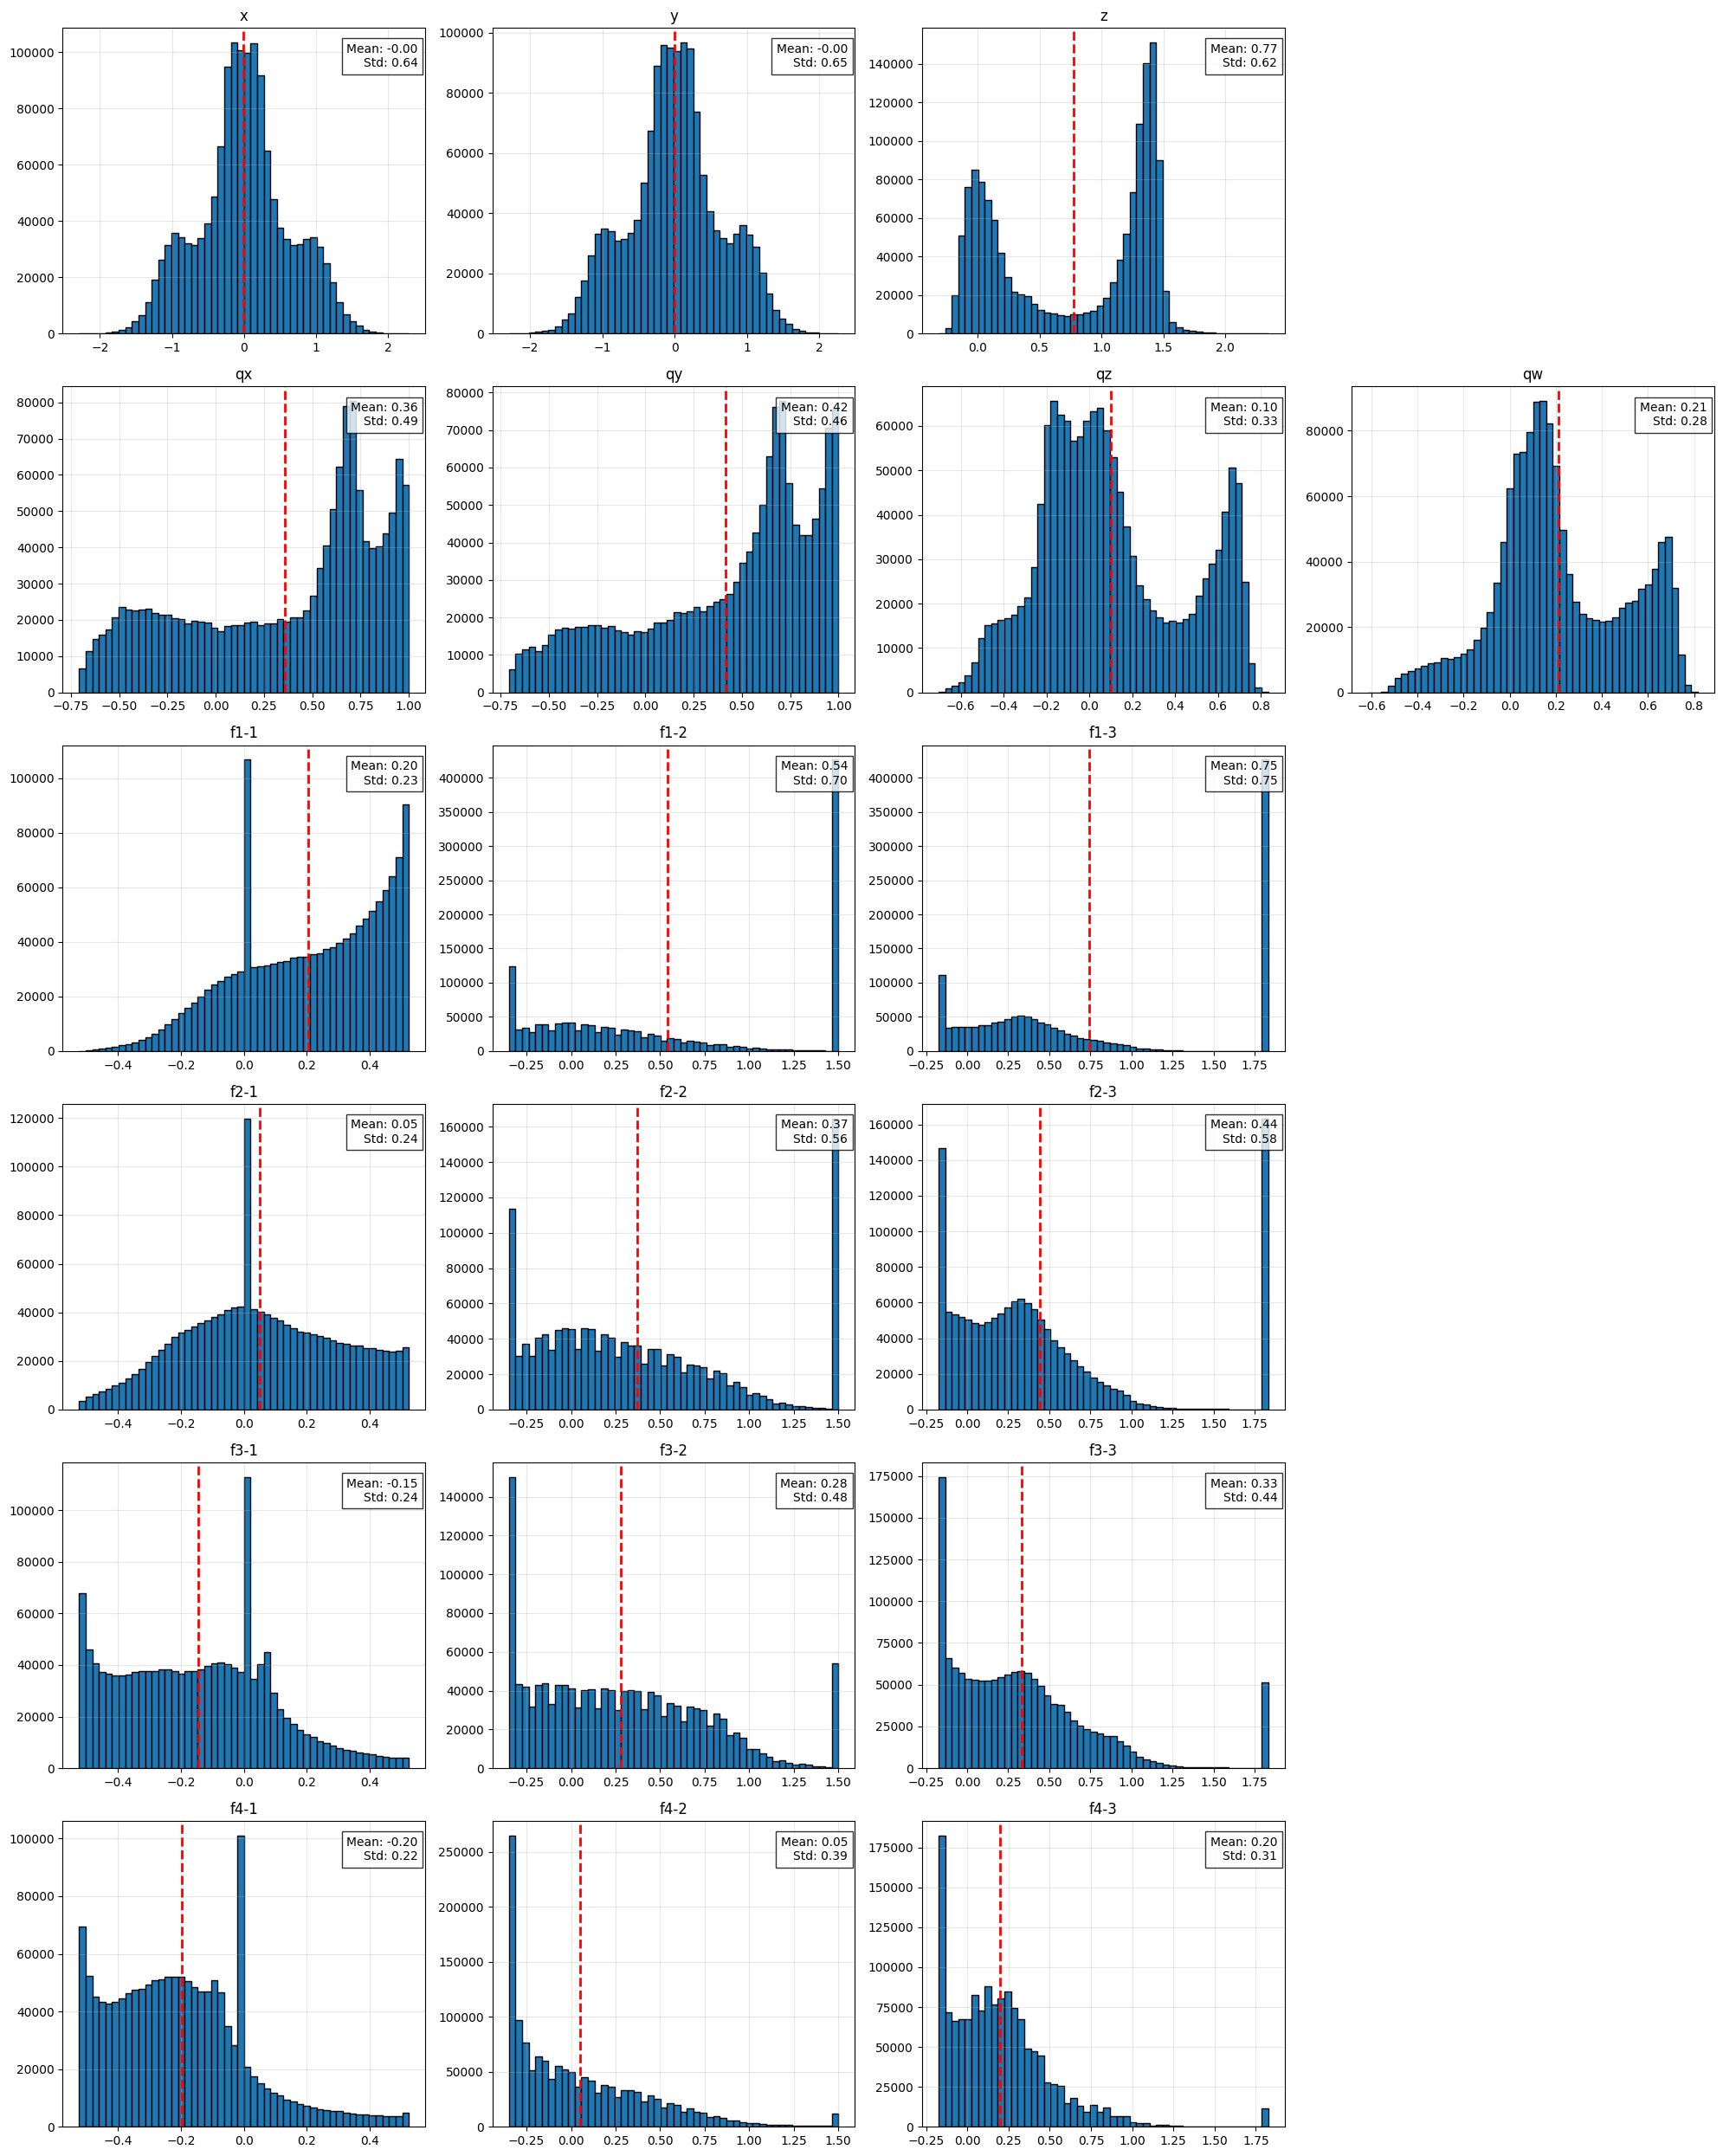

In [4]:
# Create subplots for each dimension
plot_width = 4
fig, axes = plt.subplots(6, plot_width, figsize=(20, 25))
axes = axes.flatten()

# Plot histogram for each dimension
plot_groups = [
    ["x", "y", "z"],
    ["qx", "qy", "qz", "qw"],
    ["f1-1", "f1-2", "f1-3"],
    ["f2-1", "f2-2", "f2-3"],
    ["f3-1", "f3-2", "f3-3"],
    ["f4-1", "f4-2", "f4-3"]
]

grasp_index = 0
for row, group in enumerate(plot_groups):
    for col, name in enumerate(group):
        index = row * plot_width + col
        ax = axes[index]
        values = grasps[:, grasp_index]
        grasp_index += 1
        
        # Calculate statistics
        mean = np.mean(values)
        std = np.std(values)
        
        # Create histogram
        ax.hist(values, bins=50, edgecolor='black')
        ax.axvline(mean, color='r', linestyle='dashed', linewidth=2)
        
        # Add labels and stats
        ax.set_title(f'{name}')
        ax.grid(True, alpha=0.3)
        ax.text(0.98, 0.95, f'Mean: {mean:.2f}\nStd: {std:.2f}',
                transform=ax.transAxes,
                horizontalalignment='right',
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8))
    res = plot_width - len(group)
    for i in range(res):
        axes[(row + 1) * plot_width - (i + 1)].remove()

plt.tight_layout()
plt.show()


Computing KDEs: 6it [01:20, 13.50s/it]


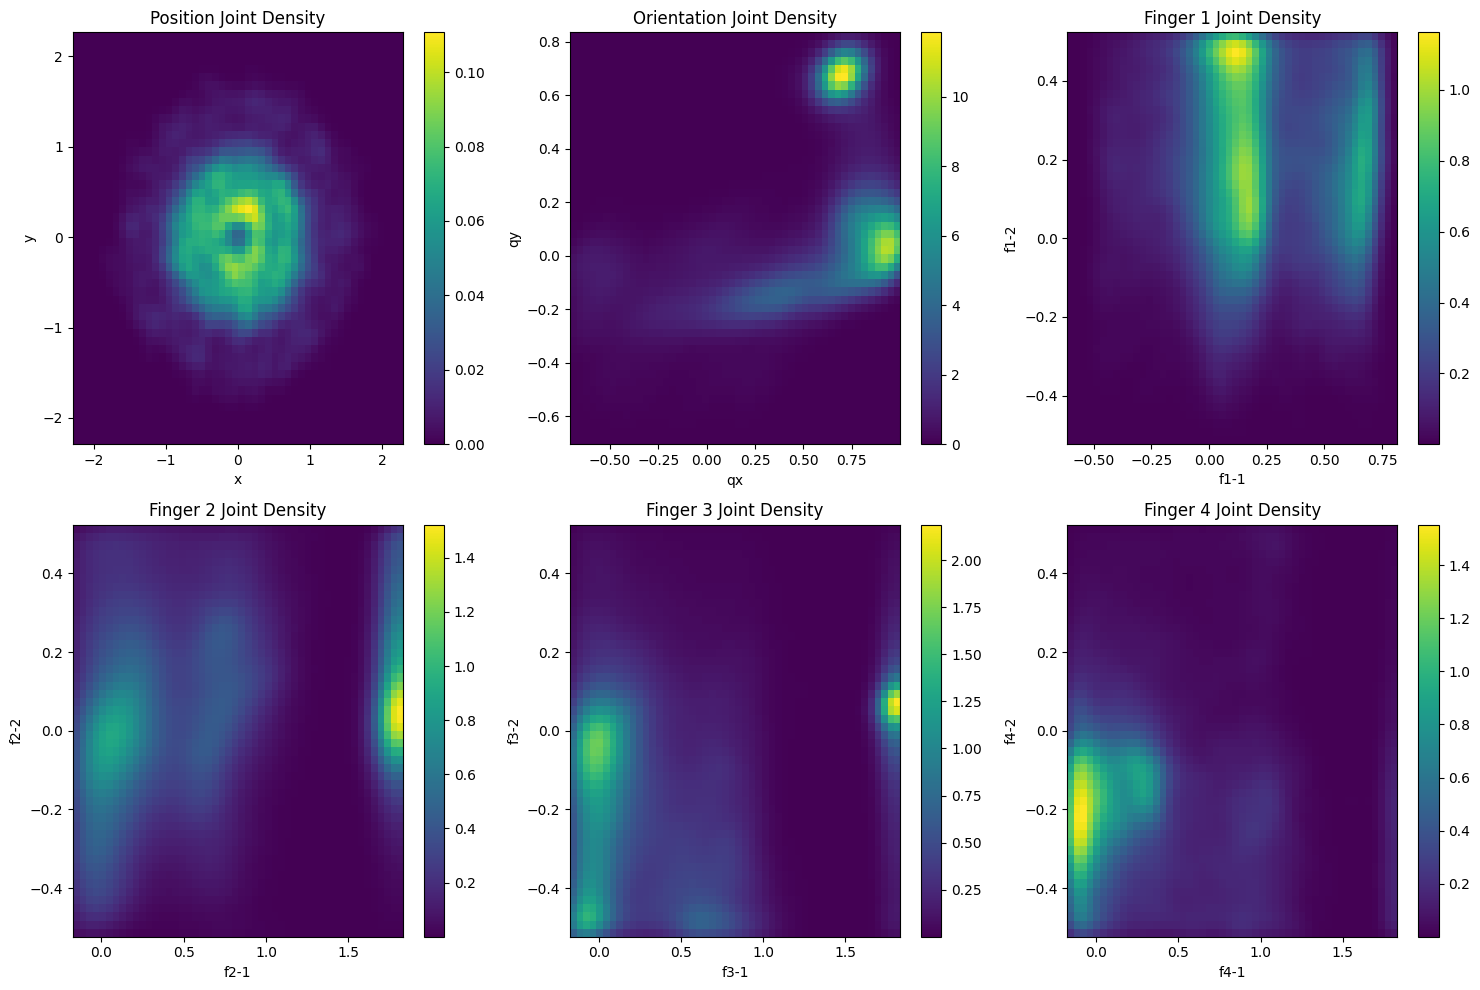

In [5]:
# Compute joint density functions for grasp parameter groups
from scipy.stats import gaussian_kde
import pickle

# Define parameter groups
param_groups = [
    ("Position", ["x", "y", "z"]),
    ("Orientation", ["qx", "qy", "qz", "qw"]), 
    ("Finger 1", ["f1-1", "f1-2", "f1-3"]),
    ("Finger 2", ["f2-1", "f2-2", "f2-3"]),
    ("Finger 3", ["f3-1", "f3-2", "f3-3"]),
    ("Finger 4", ["f4-1", "f4-2", "f4-3"])
]

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Dictionary to store KDE objects
kde_dict = {}

# Calculate and plot density for each group
for i, (group_name, params) in tqdm(enumerate(param_groups), desc="Computing KDEs"):
    # Extract data for this group
    start_idx = i * len(params)
    group_data = grasps[:, start_idx:start_idx + len(params)]
    
    # Compute kernel density estimation
    kde = gaussian_kde(group_data.T)
    # Store KDE object
    kde_dict[group_name] = kde
    
    # Generate grid of points
    grid_points = 50
    if len(params) == 3:
        x = np.linspace(group_data[:,0].min(), group_data[:,0].max(), grid_points)
        y = np.linspace(group_data[:,1].min(), group_data[:,1].max(), grid_points)
        z = np.linspace(group_data[:,2].min(), group_data[:,2].max(), grid_points)
        X, Y = np.meshgrid(x, y)
        positions = np.vstack([X.ravel(), Y.ravel(), np.full_like(X.ravel(), z.mean())])
        density = kde(positions).reshape(grid_points, grid_points)
    elif len(params) == 4:  # 4D case (quaternion)
        x = np.linspace(group_data[:,0].min(), group_data[:,0].max(), grid_points)
        y = np.linspace(group_data[:,1].min(), group_data[:,1].max(), grid_points)
        z = np.linspace(group_data[:,2].min(), group_data[:,2].max(), grid_points)
        w = np.linspace(group_data[:,3].min(), group_data[:,3].max(), grid_points)
        X, Y = np.meshgrid(x, y)
        positions = np.vstack([X.ravel(), Y.ravel(), 
                             np.full_like(X.ravel(), z.mean()),
                             np.full_like(X.ravel(), w.mean())])
        density = kde(positions).reshape(grid_points, grid_points)
    else:
        continue
    
    # Plot density
    im = axes[i].imshow(density, extent=[x.min(), x.max(), y.min(), y.max()],
                       origin='lower', aspect='auto', cmap='viridis')
    axes[i].set_title(f'{group_name} Joint Density')
    axes[i].set_xlabel(params[0])
    axes[i].set_ylabel(params[1])
    fig.colorbar(im, ax=axes[i])

# Save KDE objects to file
with open('grasp_kdes.pkl', 'wb') as f:
    pickle.dump(kde_dict, f)

plt.tight_layout()
plt.show()


# Grasp Quality Score Distribution

Loading scores: 100%|██████████| 15547/15547 [02:46<00:00, 93.48it/s] 


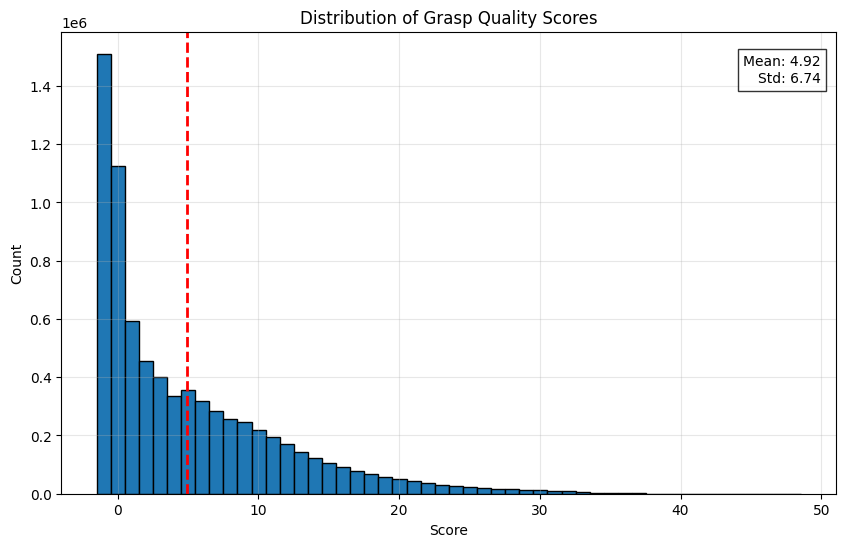

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

scores = np.array([])

# Collect scores in batches for better performance
for path in tqdm(dataset.data_files, desc="Loading scores"):
    data = np.load(path)
    scores = np.append(scores, data["scores"])

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, edgecolor='black')
plt.title('Distribution of Grasp Quality Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

# Add mean and std annotations
mean_score = np.mean(scores)
std_score = np.std(scores)
plt.axvline(mean_score, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_score:.2f}')
plt.text(0.98, 0.95, f'Mean: {mean_score:.2f}\nStd: {std_score:.2f}', 
         transform=plt.gca().transAxes, 
         horizontalalignment='right',
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

In [ ]:
# Create histogram of scores
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, edgecolor='black')
plt.title('Distribution of Grasp Quality Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

# Add mean and std annotations
mean_score = np.mean(scores)
std_score = np.std(scores)
plt.axvline(mean_score, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_score:.2f}')
plt.text(0.98, 0.95, f'Mean: {mean_score:.2f}\nStd: {std_score:.2f}', 
         transform=plt.gca().transAxes, 
         horizontalalignment='right',
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()
